In [ ]:
from fastai.tabular import *
import pandas as pd
from tqdm import tqdm

# Data preparation

In [ ]:
TARGET_COLUMN_NAME = 'close'
DATE_COLUMN_NAME = 'date'

## Get the data

In [ ]:
from datetime import datetime
df = pd.read_csv("BTC-ETH-filtered_with_indicators.csv",
                 #read dates as dates
                 parse_dates=[DATE_COLUMN_NAME], date_parser=lambda x: datetime.fromtimestamp(int(x)))

In [ ]:
df.head()

## Format the data

In [ ]:
ELAPSED = 'Elapsed'

In [ ]:
add_datepart(df, DATE_COLUMN_NAME, time=True);
df.head()

### Convert to float

In [ ]:
df = df.astype(float)
df.head()

### Check for NANs

In [ ]:
[(column, sum(df[column].isna())) for column in df.columns]

In [ ]:
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [ ]:
df.describe(include="all")

In [ ]:
drop_columns=['Second', 'Month', 'Year', \
              'Is_quarter_end', 'Is_quarter_start', \
              'Is_year_end', 'Is_year_start',
              'Is_month_end', 'Is_month_start',
              'Week', 'Dayofyear']

In [ ]:
df = df.drop(columns=drop_columns)
df.shape

In [ ]:
df.describe(include="all")

In [ ]:
True_target_column_name = TARGET_COLUMN_NAME+'_future'

In [ ]:
df[True_target_column_name] = df[TARGET_COLUMN_NAME].shift(-4)

In [ ]:
df.head(10)

## Prepare train valid test

In [ ]:
# TRAIN_VALID_TEST_SPLIT_RATIOS
trvate_split = tuple(int(x * len(df)) for x in (0.75, 0.9, 1.0))
print([int(len(df)* x) for x in (0.75, 0.15, 0.1)])
trvate_split

Search for batch size using http://www.alcula.com/calculators/math/gcd/

In [ ]:
BATCH_SIZE = 24

In [ ]:
tmp_train_limit = trvate_split[0]-trvate_split[0]%BATCH_SIZE
train_df = df[:tmp_train_limit]

tmp_valid_limit = trvate_split[1] -trvate_split[0]%BATCH_SIZE -(trvate_split[1]-trvate_split[0])%BATCH_SIZE
valid_df = df[tmp_train_limit:tmp_valid_limit]

test_df = df[tmp_valid_limit:(len(df)- len(df)%BATCH_SIZE)]

len(train_df), len(valid_df), len(test_df)

In [ ]:
def input_data(self: pd.DataFrame):
    return self.drop(columns=[True_target_column_name])
def target(self: pd.DataFrame):
    return self[[True_target_column_name]]

pd.DataFrame.input_data = input_data
pd.DataFrame.target = target

In [ ]:
df.input_data().head()

In [ ]:
print('df.shape', df.shape)
print('train_df.shape', train_df.shape)
print('valid_df.shape', valid_df.shape)
print('test_df.shape', test_df.shape)

## Normalize

In [ ]:
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from sklearn.pipeline import Pipeline
preprocessing_pipeline = Pipeline([
     ("poli-feature", PolynomialFeatures(degree=2)),
     ("normalizer", StandardScaler())
]).fit(train_df.input_data(), train_df.target())

In [ ]:
def transform_df(df_to_transform, transformer, columns):
    return pd.DataFrame(transformer.transform(df_to_transform), columns=columns)
    

In [ ]:
# preprocessing_pipeline["poli-feature"].get_feature_names(valid_df.columns)

In [ ]:
#std scaler
# std_scaler = StandardScaler()
# std_scaler.fit(train_df)

# train_data = transform_df(train_df, std_scaler, columns=train_df.columns)
# valid_data = transform_df(valid_df, std_scaler, columns=valid_df.columns)
# test_data = transform_df(test_df, std_scaler, columns=test_df.columns)

#poly transform
poly_features = PolynomialFeatures(degree=2)
temp = train_df.input_data()
poly_features.fit(temp)
temp = poly_features.get_feature_names(temp.columns)

train_data = transform_df(train_df.input_data(), preprocessing_pipeline, columns=temp)
valid_data = transform_df(valid_df.input_data(), preprocessing_pipeline, columns=temp)
test_data = transform_df(test_df.input_data(), preprocessing_pipeline, columns=temp)

del temp

train_data.drop(columns=['1'], inplace=True)
valid_data.drop(columns=['1'], inplace=True)
test_data.drop(columns=['1'], inplace=True)

train_data.head()

In [ ]:
train_data.describe(include="all")

# Train

In [ ]:
import torch
from torch.utils.data import TensorDataset, DataLoader
import torch.nn as nn

## DataLoaders

In [ ]:
train_loader = DataLoader(TensorDataset(torch.from_numpy(train_data.values),
                                        torch.from_numpy(train_df.target().values)),
                          shuffle=False, batch_size=BATCH_SIZE)
val_loader = DataLoader(TensorDataset(torch.from_numpy(valid_data.values),
                                      torch.from_numpy(valid_df.target().values)),
                        shuffle=False, batch_size=BATCH_SIZE)
test_loader = DataLoader(TensorDataset(torch.from_numpy(test_data.values),
                                       torch.from_numpy(test_df.target().values)),
                         shuffle=False, batch_size=BATCH_SIZE)

In [ ]:
# torch.cuda.is_available() checks and returns a Boolean True if a GPU is available, else it'll return False
# If we have a GPU available, we'll set our device to GPU. We'll use this device variable later in our code.
DEVICE = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
DEVICE

## Model

In [ ]:
class SentimentNet(nn.Module):
    def __init__(self, features, output_size=1,
#                  embedding_dim=10,
#                  hidden_dim=50,
                 n_layers=1,
                 drop_prob=0.5, device=torch.device("cpu")):
        super(SentimentNet, self).__init__()
        
        embedding_dim=features*2
        hidden_dim=features
        
        self.output_size = output_size
        self.n_layers = n_layers
        self.hidden_dim = hidden_dim
        self.device = device
        
        self.liniar = nn.Linear(features, embedding_dim)
        self.bn1 = nn.BatchNorm1d(num_features=embedding_dim)
        
        self.lstm = nn.LSTM(input_size=embedding_dim,
                            hidden_size=hidden_dim,
                            num_layers=n_layers, dropout=drop_prob, batch_first=True)
#         self.dropout = nn.Dropout(drop_prob)
        self.fc = nn.Sequential(nn.Linear(hidden_dim, hidden_dim//2),
                                nn.BatchNorm1d(num_features=hidden_dim//2),
                                nn.Dropout(drop_prob),
                                nn.Tanh(),
                                nn.Linear(hidden_dim//2, output_size))
        
    def forward(self, x, hidden):
        batch_size = x.size(0)
        x = x.float()
        
        liniar = F.relu(self.bn1(self.liniar(x)))
        lstm_out, hidden = self.lstm(liniar.view(batch_size, -1, liniar.shape[1]),
                                     (hidden[0][:,-batch_size:,:],# hidden
                                      hidden[1][:,-batch_size:,:]))# cell state
        lstm_out = lstm_out.contiguous().view(-1, self.hidden_dim)
#         out = self.dropout(lstm_out)
        out = self.fc(lstm_out)
        
        out = out.view(batch_size, -1)
#         out = out[:,-1]
        return out, hidden
    
    def init_hidden(self, batch_size):
        weight = next(self.parameters()).data
        
        hidden = (weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device), # hidden
                  weight.new(self.n_layers, batch_size, self.hidden_dim).zero_().to(self.device)) # cell state
        return hidden

In [ ]:
features_count = train_data.shape[1]
# output_size = 1
# embedding_dim = 400
# hidden_dim = 512
# n_layers = 2

model = SentimentNet(features_count, device=DEVICE, n_layers=2)
model.to(DEVICE)

lr=0.0003
criterion = nn.L1Loss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

In [ ]:
epochs = 100
counter = 0
print_every = 1
clip = 5
valid_loss_min = np.Inf
lr_scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr=lr,
                                                   steps_per_epoch=len(train_loader),
                                                   epochs=epochs)

model.train()
for i in range(epochs):
    h = model.init_hidden(BATCH_SIZE)
    
    for inputs, labels in train_loader:
        counter += 1
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
        model.zero_grad()
        optimizer.zero_grad()
        output, h = model(inputs, h)
        h = tuple([e.data for e in h])
        loss = criterion(output.squeeze(), labels.float())
        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        lr_scheduler.step()
        
        if counter%print_every == 0:
            val_h = tuple([each.data for each in h])#model.init_hidden(BATCH_SIZE)
            val_losses = []
            model.eval()
            for inp, lab in val_loader:
                val_h = tuple([each.data for each in val_h])
                inp, lab = inp.to(DEVICE), lab.to(DEVICE)
                out, val_h = model(inp, val_h)
                val_loss = criterion(out.squeeze(), lab.float())
                val_losses.append(val_loss.item())

            model.train()
            print("Epoch: {}/{}...".format(i+1, epochs),
                  "Step: {}...".format(counter),
                  "Loss: {:.6f}...".format(loss.item()),
                  "Val Loss: {:.6f}".format(np.mean(val_losses)))
            if np.mean(val_losses) < valid_loss_min:
                torch.save(model.state_dict(), './state_dict.pt')
                print('Validation loss decreased ({:.6f} --> {:.6f}).  Saving model ...'.format(valid_loss_min,np.mean(val_losses)))
                valid_loss_min = np.mean(val_losses)

# Test

## Visualize

In [ ]:
import matplotlib.pyplot as plt

class Visualizer:
    colors=['blue','black', 'red']
    
    def __init__(self):
        self.date_pred_targ_dict: dict = dict()
        
    def add(self, timestamp, pred, targ, color='red'):
        self.date_pred_targ_dict[color] = pd.concat([self.date_pred_targ_dict.get(color, pd.DataFrame()),
                                                     pd.concat([pd.DataFrame(timestamp),
                                                       pd.DataFrame(pred),
                                                       pd.DataFrame(targ)], axis=1)])
    
    def plot(self):
        for color in self.colors:
            color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
            plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
            plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
        plt.show()

## Eval

In [ ]:
# Loading the best model
model.load_state_dict(torch.load('./state_dict.pt'))
visualizer = Visualizer()

mse_losses = []
mae_losses = []
kldiv_losses = []
num_correct = 0
custom_batch = BATCH_SIZE
index_of_elapsed = train_data.columns.tolist().index(ELAPSED)

h = model.init_hidden(custom_batch)

model.eval()
for inputs, labels in tqdm(train_loader):
    if inputs.shape[0] != custom_batch:
        continue
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    output, h = model(inputs, h)
    visualizer.add(inputs[:,index_of_elapsed], output, labels[:,-1], color='black')
    
for inputs, labels in tqdm(val_loader):
    if inputs.shape[0] != custom_batch:
        continue
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    output, h = model(inputs, h)
    visualizer.add(inputs[:,index_of_elapsed], output, labels[:,-1], color='blue')
    
for inputs, labels in tqdm(test_loader):
    if inputs.shape[0] != custom_batch:
        continue
    inputs, labels = inputs.to(DEVICE), labels.to(DEVICE)
    output, h = model(inputs, h)
    visualizer.add(inputs[:,index_of_elapsed], output, labels[:,-1])
    mse_losses.append(nn.MSELoss()(output.squeeze(), labels.float()).item())
    mae_losses.append(nn.L1Loss()(output.squeeze(), labels.float()).item())
    kldiv_losses.append(nn.KLDivLoss()(output.squeeze(), labels.float()).item())
    

print("MSE loss: {:.8f}".format(np.mean(mse_losses)))
print("MAE loss: {:.8f}".format(np.mean(mae_losses)))
print("KLDiv loss: {:.8f}".format(np.mean(kldiv_losses)))

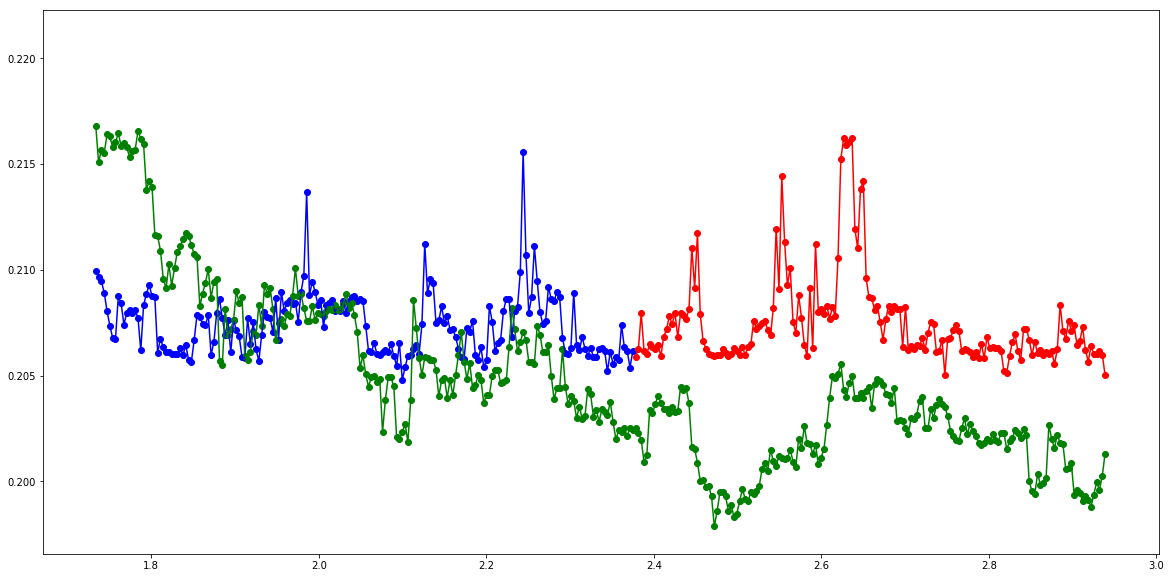

In [120]:
plt.figure(figsize=(20,10))
# visualizer.plot()
for color in ['blue', 'red']:
# for color in ['red']:
    color_df = visualizer.date_pred_targ_dict.get(color, pd.DataFrame())
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -2]*10, color=color)
    plt.scatter(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
    plt.plot(color_df.iloc[:,0], color_df.iloc[:, -1]*10, color='g')
plt.show()

Hyperparameters:

- model:
    - embedding_dim=features*2   ✓
    - hidden_dim=features*16  ✓
- learning rate  
- batch size (window size?)
- DONE - DID IMPROVE criterion = nn.MSELoss()   ✓
    - try a loss which scales through time. ✓
- optimizer = torch.optim.Adam(model.parameters(), lr=lr)
- add polynomial features ✓